# Multimodal RAG with LangChain

#### Installation packages

- pip install -U langchain openai langchain-chroma langchain-experimental
- pip install "unstructured[all-docs]" pillow pydantic lxml pillow matplotlib chromadb tiktoken

- Path to Tesseract for OCR

In [1]:
import unstructured_pytesseract as pytesseract

pytesseract.pytesseract.tesseract_cmd = "C:\\Program Files\\Tesseract-OCR\\tesseract.exe"

### 1. Partition PDF tables, text, and images

- We will use Unstructured to extract text, images, tables and break them into chunks

In [2]:
from langchain_text_splitters import CharacterTextSplitter
from unstructured.partition.pdf import partition_pdf
import os
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

c:\Users\Pigeon\anaconda3\envs\rag_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Extract elements from PDF
def extract_pdf_elements(path, fname):
    """
    Extract images, tables, and chunk text from a PDF file.
    path: File path, which is used to dump images (.jpg)
    fname: File name
    """
    return partition_pdf(
        filename                    = os.path.join(fpath, fname),
        extract_images_in_pdf       = True,
        infer_table_structure       = True,
        chunking_strategy           = "by_title",
        max_characters              = 4000,
        new_after_n_chars           = 3800,
        combine_text_under_n_chars  = 2000,
        image_output_dir_path       = path,
    )


# Categorize elements by type
def categorize_elements(raw_pdf_elements):
    """
    Categorize extracted elements from a PDF into tables and texts.
    raw_pdf_elements: List of unstructured.documents.elements
    """
    tables = []
    texts = []
    for element in raw_pdf_elements:
        if "unstructured.documents.elements.Table" in str(type(element)):
            tables.append(str(element))
        elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
            texts.append(str(element))
    return texts, tables


# File path with name
fpath = os.getcwd()
fname = "rflr-performance-attribution.pdf"

# Get elements
raw_pdf_elements = extract_pdf_elements(fpath, fname)

# Get text, tables
texts, tables = categorize_elements(raw_pdf_elements)

# Optional: Enforce a specific token size for texts
text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=4000, chunk_overlap=500
)
joined_texts = " ".join(texts)
texts_4k_token = text_splitter.split_text(joined_texts)

In [4]:
raw_pdf_elements

In [5]:
texts_4k_token

['CFA INSTITUTE RESEARCH FOUNDATION / LITERATURE REVIEW\n\nPERFORMANCE ATTRIBUTION HISTORY AND PROGRESS\n\nCARL BACON, CIPM WJ CFA Institute NY Research I> Foundation\n\nResearch Foundation Literature Review\n\nPERFORMANCE ATTRIBUTION History and Progress\n\nCarl Bacon, CIPM\n\nNI Ny I\\>\n\nCFA Institute Research Foundation\n\nStatement of Purpose\n\nThe CFA Institute Research Foundation is a not- for-profit organization established to promote the development and dissemination of relevant research for investment practitioners worldwide.\n\nNeither CFA Institute Research Foundation, CFA Institute, nor the publication’s editorial staff is responsible for facts and opinions presented in this publication. This publication reflects the views of the author(s) and does not represent the official views of CFA Institute Research Foundation.\n\nCFA®, Chartered Financial Analyst®, and GIPS® are just a few of the trademarks owned by CFA Institute. To view a list of CFA Institute trademarks and th

In [6]:
texts_4k_token_processed = []
for text in texts_4k_token:
    new_text = text.replace('\n', ' ')
    texts_4k_token_processed.append(new_text)

In [7]:
texts_4k_token_processed

['CFA INSTITUTE RESEARCH FOUNDATION / LITERATURE REVIEW  PERFORMANCE ATTRIBUTION HISTORY AND PROGRESS  CARL BACON, CIPM WJ CFA Institute NY Research I> Foundation  Research Foundation Literature Review  PERFORMANCE ATTRIBUTION History and Progress  Carl Bacon, CIPM  NI Ny I\\>  CFA Institute Research Foundation  Statement of Purpose  The CFA Institute Research Foundation is a not- for-profit organization established to promote the development and dissemination of relevant research for investment practitioners worldwide.  Neither CFA Institute Research Foundation, CFA Institute, nor the publication’s editorial staff is responsible for facts and opinions presented in this publication. This publication reflects the views of the author(s) and does not represent the official views of CFA Institute Research Foundation.  CFA®, Chartered Financial Analyst®, and GIPS® are just a few of the trademarks owned by CFA Institute. To view a list of CFA Institute trademarks and the Guide for the Use of

In [8]:
texts

['CFA INSTITUTE RESEARCH FOUNDATION / LITERATURE REVIEW\n\nPERFORMANCE ATTRIBUTION HISTORY AND PROGRESS\n\nCARL BACON, CIPM WJ CFA Institute NY Research I> Foundation\n\nResearch Foundation Literature Review\n\nPERFORMANCE ATTRIBUTION History and Progress\n\nCarl Bacon, CIPM\n\nNI Ny I\\>\n\nCFA Institute Research Foundation\n\nStatement of Purpose\n\nThe CFA Institute Research Foundation is a not- for-profit organization established to promote the development and dissemination of relevant research for investment practitioners worldwide.\n\nNeither CFA Institute Research Foundation, CFA Institute, nor the publication’s editorial staff is responsible for facts and opinions presented in this publication. This publication reflects the views of the author(s) and does not represent the official views of CFA Institute Research Foundation.\n\nCFA®, Chartered Financial Analyst®, and GIPS® are just a few of the trademarks owned by CFA Institute. To view a list of CFA Institute trademarks and th

In [9]:
texts_processed = []
for text in texts:
    new_text = text.replace('\n', ' ')
    texts_processed.append(new_text)

In [10]:
texts_processed

['CFA INSTITUTE RESEARCH FOUNDATION / LITERATURE REVIEW  PERFORMANCE ATTRIBUTION HISTORY AND PROGRESS  CARL BACON, CIPM WJ CFA Institute NY Research I> Foundation  Research Foundation Literature Review  PERFORMANCE ATTRIBUTION History and Progress  Carl Bacon, CIPM  NI Ny I\\>  CFA Institute Research Foundation  Statement of Purpose  The CFA Institute Research Foundation is a not- for-profit organization established to promote the development and dissemination of relevant research for investment practitioners worldwide.  Neither CFA Institute Research Foundation, CFA Institute, nor the publication’s editorial staff is responsible for facts and opinions presented in this publication. This publication reflects the views of the author(s) and does not represent the official views of CFA Institute Research Foundation.  CFA®, Chartered Financial Analyst®, and GIPS® are just a few of the trademarks owned by CFA Institute. To view a list of CFA Institute trademarks and the Guide for the Use of

In [11]:
texts_4k_token = texts_4k_token_processed
texts = texts_processed

### 2. Multi-vector retriever
- Use multi-vector-retriever to index image (and / or text, table) summaries, but retrieve raw images (along with raw texts or tables).
- Use GPT-4o to produce table and, optionall, text summaries.

In [12]:
# Generate summaries of text elements
def generate_text_summaries(texts, tables, summarize_texts=False):
    """
    Summarize text elements
    texts: List of str
    tables: List of str
    summarize_texts: Bool to summarize texts
    """

    # Prompt
    prompt_text = """You are an assistant tasked with summarizing tables and text for retrieval. \
    These summaries will be embedded and used to retrieve the raw text or table elements. \
    Give a concise summary of the table or text that is well optimized for retrieval. Table or text: {element} """
    prompt = ChatPromptTemplate.from_template(prompt_text)

    # Text summary chain
    model = ChatOpenAI(
        temperature     = 0, 
        model           = "gpt-4o",
        api_key         = "OPEN_AI_API_KEY"
    )
    summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

    # Initialize empty summaries
    text_summaries = []
    table_summaries = []

    # Apply to text if texts are provided and summarization is requested
    if texts and summarize_texts:
        text_summaries = summarize_chain.batch(texts, {"max_concurrency": 5})
    elif texts:
        text_summaries = texts

    # Apply to tables if tables are provided
    if tables:
        table_summaries = summarize_chain.batch(tables, {"max_concurrency": 5})

    return text_summaries, table_summaries


# Get text, table summaries
text_summaries, table_summaries = generate_text_summaries(
    texts_4k_token, tables, summarize_texts=False
)

In [13]:
text_summaries

['CFA INSTITUTE RESEARCH FOUNDATION / LITERATURE REVIEW  PERFORMANCE ATTRIBUTION HISTORY AND PROGRESS  CARL BACON, CIPM WJ CFA Institute NY Research I> Foundation  Research Foundation Literature Review  PERFORMANCE ATTRIBUTION History and Progress  Carl Bacon, CIPM  NI Ny I\\>  CFA Institute Research Foundation  Statement of Purpose  The CFA Institute Research Foundation is a not- for-profit organization established to promote the development and dissemination of relevant research for investment practitioners worldwide.  Neither CFA Institute Research Foundation, CFA Institute, nor the publication’s editorial staff is responsible for facts and opinions presented in this publication. This publication reflects the views of the author(s) and does not represent the official views of CFA Institute Research Foundation.  CFA®, Chartered Financial Analyst®, and GIPS® are just a few of the trademarks owned by CFA Institute. To view a list of CFA Institute trademarks and the Guide for the Use of

- Use GPT-4o to generate summaries of all the images that were extracted

In [14]:
import base64
import os

from langchain_core.messages import HumanMessage


def encode_image(image_path):
    """Getting the base64 string"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


def image_summarize(img_base64, prompt):
    """Make image summary"""
    chat = ChatOpenAI(
        model       = "gpt-4o", 
        max_tokens  = 1024,
        api_key     = "OPEN_AI_API_KEY"
    )

    msg = chat.invoke(
        [
            HumanMessage(
                content=[
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"},
                    },
                ]
            )
        ]
    )
    return msg.content


def generate_img_summaries(path):
    """
    Generate summaries and base64 encoded strings for images
    path: Path to list of .jpg files extracted by Unstructured
    """

    # Store base64 encoded images
    img_base64_list = []

    # Store image summaries
    image_summaries = []

    # Prompt
    prompt = """You are an assistant tasked with summarizing images for retrieval. \
    These summaries will be embedded and used to retrieve the raw image. \
    Give a concise summary of the image that is well optimized for retrieval."""

    # Apply to images
    for img_file in sorted(os.listdir(path)):
        if img_file.endswith(".jpg"):
            img_path = os.path.join(path, img_file)
            base64_image = encode_image(img_path)
            img_base64_list.append(base64_image)
            image_summaries.append(image_summarize(base64_image, prompt))

    return img_base64_list, image_summaries


# Image summaries
img_base64_list, image_summaries = generate_img_summaries(os.path.join(fpath, "figures"))

print(os.path.join(fpath, "figures"))
print(image_summaries)

c:\Users\Pigeon\ClassWork\Semester3\Courses\BigDataIA\Assignment3\airflow\POC\MLR\figures
['CFA Institute Research Foundation cover featuring modern architecture with circular and linear elements, predominantly in red and grey tones. Includes text "Carl Bacon, CIPM" and CFA Institute logo.', "Graph depicting the relationship between systematic risk (beta) and return, with a line indicating return from systematic risk. Points labeled A, A', and A'' show net selectivity and diversification. Vertical and horizontal axes represent systematic risk and return, respectively.", 'Bar chart illustrating four components of investment return: Selection, Interaction, Benchmark Contribution, and Allocation, with labels and mathematical expressions for each section.', 'Matrix diagram with labeled sections: "Selection" (top left, blue), "Interaction" (top right, striped), "Allocation" (middle right, blue). Axes labeled \\(r_i\\), \\(b_i\\), \\(b\\) (vertical) and \\(W_i\\), \\(w_i\\) (horizontal). Mat

In [16]:
import uuid
import json

def save_preprocessed_context(texts, text_summaries, tables, table_summaries, img_base64_list, image_summaries):

    texts_uuid_list  = [str(uuid.uuid4()) for _ in texts]
    tables_uuid_list = [str(uuid.uuid4()) for _ in tables]
    images_uuid_list = [str(uuid.uuid4()) for _ in img_base64_list]

    data = {
        "texts"             : texts,
        "text_summaries"    : text_summaries,
        "texts_uuid_list"   : texts_uuid_list,
        "tables"            : tables,
        "table_summaries"   : table_summaries,
        "tables_uuid_list"  : tables_uuid_list,
        "img_base64_list"   : img_base64_list,
        "image_summaries"   : image_summaries,
        "images_uuid_list"  : images_uuid_list
    }

    file_name = "preprocessed_context.json"
    output_path = os.path.join(os.getcwd(), file_name)
    
    with open(output_path, "w") as file:
        json.dump(data, file, indent=4)

save_preprocessed_context(texts, text_summaries, tables, table_summaries, img_base64_list, image_summaries)

### 3. Store everything in Chroma Vectorstore

- Store the raw texts, tables, and images in the docstore (In-memory)
- Store the texts, table summaries, and image summaries in the vectorstore for efficient semantic retrieval

In [17]:
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings


def create_multi_vector_retriever(
    vectorstore, 
    text_summaries, 
    texts, 
    texts_uuid_list, 
    table_summaries, 
    tables, 
    tables_uuid_list, 
    image_summaries, 
    images, 
    images_uuid_list
):
    """
    Create retriever that indexes summaries, 
    but returns raw images or texts
    """

    # Initialize the storage layer
    store = InMemoryStore()
    id_key = "doc_id"

    # Create the multi-vector retriever
    retriever = MultiVectorRetriever(
        vectorstore = vectorstore,
        docstore    = store,
        id_key      = id_key,
        search_type = "similarity",

        # Limit the number of documents k returned by the retriever
        search_kwargs = {
            "k": 6
        }
    )

    # Helper function to add documents to the vectorstore and docstore
    def add_documents(retriever, doc_summaries, doc_contents, doc_uuids):
        doc_ids = doc_uuids
        summary_docs = [
            Document(
                page_content = s, 
                metadata = {
                    "doc_id": doc_ids[i],
                    "content": doc_contents[i]  # Store the original content in metadata
                }
            )
            for i, s in enumerate(doc_summaries)
        ]
        retriever.vectorstore.add_documents(summary_docs)
        retriever.docstore.mset(list(zip(doc_ids, doc_contents)))

    # Add texts, tables, and images
    # Check that text_summaries is not empty before adding
    if text_summaries:
        add_documents(retriever, text_summaries, texts, texts_uuid_list)
    # Check that table_summaries is not empty before adding
    if table_summaries:
        add_documents(retriever, table_summaries, tables, tables_uuid_list)
    # Check that image_summaries is not empty before adding
    if image_summaries:
        add_documents(retriever, image_summaries, images, images_uuid_list)

    return retriever


# The vectorstore to use to index the summaries
vectorstore = Chroma(
    collection_name     = "Multimodal_RAG_collection_PDF1", 
    embedding_function  = OpenAIEmbeddings(
        api_key = "OPEN_AI_API_KEY"
    ),
    persist_directory   = "./MLR_with_langchain_database"
)

file_name = "preprocessed_context.json"
file_path = os.path.join(os.getcwd(), file_name)

text_summaries = texts = texts_uuid_list = []
table_summaries = tables = tables_uuid_list = [] 
image_summaries = img_base64_list = images_uuid_list = []

with open(file_path, "r") as file:
    data = json.load(file)
    
    text_summaries = data["text_summaries"]
    texts = data["texts"]
    texts_uuid_list = data["texts_uuid_list"]
    
    table_summaries = data["table_summaries"]
    tables = data["tables"]
    tables_uuid_list = data["tables_uuid_list"]
    
    image_summaries = data["image_summaries"]
    img_base64_list = data["img_base64_list"]
    images_uuid_list = data["images_uuid_list"]

# Create retriever
retriever_multi_vector_img = create_multi_vector_retriever(
    vectorstore,
    text_summaries,
    texts,
    texts_uuid_list,
    table_summaries,
    tables,
    tables_uuid_list,
    image_summaries,
    img_base64_list,
    images_uuid_list
)

In [18]:
text_summaries

['CFA INSTITUTE RESEARCH FOUNDATION / LITERATURE REVIEW  PERFORMANCE ATTRIBUTION HISTORY AND PROGRESS  CARL BACON, CIPM WJ CFA Institute NY Research I> Foundation  Research Foundation Literature Review  PERFORMANCE ATTRIBUTION History and Progress  Carl Bacon, CIPM  NI Ny I\\>  CFA Institute Research Foundation  Statement of Purpose  The CFA Institute Research Foundation is a not- for-profit organization established to promote the development and dissemination of relevant research for investment practitioners worldwide.  Neither CFA Institute Research Foundation, CFA Institute, nor the publication’s editorial staff is responsible for facts and opinions presented in this publication. This publication reflects the views of the author(s) and does not represent the official views of CFA Institute Research Foundation.  CFA®, Chartered Financial Analyst®, and GIPS® are just a few of the trademarks owned by CFA Institute. To view a list of CFA Institute trademarks and the Guide for the Use of

In [19]:
texts

['CFA INSTITUTE RESEARCH FOUNDATION / LITERATURE REVIEW  PERFORMANCE ATTRIBUTION HISTORY AND PROGRESS  CARL BACON, CIPM WJ CFA Institute NY Research I> Foundation  Research Foundation Literature Review  PERFORMANCE ATTRIBUTION History and Progress  Carl Bacon, CIPM  NI Ny I\\>  CFA Institute Research Foundation  Statement of Purpose  The CFA Institute Research Foundation is a not- for-profit organization established to promote the development and dissemination of relevant research for investment practitioners worldwide.  Neither CFA Institute Research Foundation, CFA Institute, nor the publication’s editorial staff is responsible for facts and opinions presented in this publication. This publication reflects the views of the author(s) and does not represent the official views of CFA Institute Research Foundation.  CFA®, Chartered Financial Analyst®, and GIPS® are just a few of the trademarks owned by CFA Institute. To view a list of CFA Institute trademarks and the Guide for the Use of

In [20]:
table_summaries

['This document outlines various aspects of attribution methodologies, including early development, foundational concepts, multiperiod and multicurrency analysis, and different types of attribution. It also covers risk-adjusted and fixed-income attribution, along with other related issues. The conclusion discusses the evolution of these methodologies.',
 'Summary: Comparison of actual fund against partly and fully restrained funds.',
 'This text describes a framework for portfolio management divided into four quadrants: Quadrant I (Policy & Selection), Quadrant II (Policy & Timing), Quadrant III (Passive), and Quadrant IV (Active). It includes formulas for calculating portfolio return (Σ wi × ri) and benchmark return (Σ wi × bi) for active management, and similar formulas (Σ Wi × ri and Σ Wi × bi) for passive management.',
 'This text outlines a sequence or hierarchy involving timing and security selection, with a progression from "Timing II" to "I," "Security Selection III" to "I," an

In [21]:
image_summaries

['Cover design featuring modern architecture with curved glass and metallic elements, overlaid with red geometric shapes. Text includes "Carl Bacon, CIPM" and "CFA Institute Research Foundation" logo.',
 "Graph illustrating the relationship between systematic risk (beta) and return, with lines indicating return from systematic risk and selectivity. Points A and A'' are marked, showing net selectivity and diversification. Axes labeled as return versus systematic risk.",
 'Chart illustrating a financial attribution model with four sections: Selection, Interaction, Benchmark Contribution, and Allocation. Each section has a formula, and the chart is divided by axes labeled \\(r_i\\) and \\(w_i\\).',
 'Matrix diagram with four sections labeled Selection, Interaction, Allocation, and another unlabeled. Each section includes mathematical expressions. Axes are labeled \\(r_i\\), \\(b_i\\), \\(b\\), \\(W_i\\), and \\(w_i\\). Color-coded with blue and striped patterns.',
 'Geometric logo with bl

### 4. RAG
- Build retriever to fetch relevant text and images (Multimodal retreiver)

In [22]:
import io
import re

from IPython.display import HTML, display
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from PIL import Image


def plt_img_base64(img_base64):
    """Disply base64 encoded string as image"""
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    # Display the image by rendering the HTML
    display(HTML(image_html))


def looks_like_base64(sb):
    """Check if the string looks like base64"""
    return re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None


def is_image_data(b64data):
    """
    Check if the base64 data is an image by looking at the start of the data
    """
    image_signatures = {
        b"\xff\xd8\xff": "jpg",
        b"\x89\x50\x4e\x47\x0d\x0a\x1a\x0a": "png",
        b"\x47\x49\x46\x38": "gif",
        b"\x52\x49\x46\x46": "webp",
    }
    try:
        header = base64.b64decode(b64data)[:8]  # Decode and get the first 8 bytes
        for sig, format in image_signatures.items():
            if header.startswith(sig):
                return True
        return False
    except Exception:
        return False


def resize_base64_image(base64_string, size=(128, 128)):
    """
    Resize an image encoded as a Base64 string
    """
    # Decode the Base64 string
    img_data = base64.b64decode(base64_string)
    img = Image.open(io.BytesIO(img_data))

    # Resize the image
    resized_img = img.resize(size, Image.LANCZOS)

    # Save the resized image to a bytes buffer
    buffered = io.BytesIO()
    resized_img.save(buffered, format=img.format)

    # Encode the resized image to Base64
    return base64.b64encode(buffered.getvalue()).decode("utf-8")


def split_image_text_types(docs):
    """
    Split base64-encoded images and texts
    """
    b64_images = []
    texts = []
    for doc in docs:
        # Check if the document is of type Document and extract page_content if so
        if isinstance(doc, Document):
            doc = doc.page_content
        if looks_like_base64(doc) and is_image_data(doc):
            doc = resize_base64_image(doc, size=(1300, 600))
            b64_images.append(doc)
        else:
            texts.append(doc)
    return {"images": b64_images, "texts": texts}


def img_prompt_func(data_dict, prompt_type = "full_text"):
    """
    Join the context into a single string
    """
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # Adding image(s) to the messages if present
    if data_dict["context"]["images"]:
        for image in data_dict["context"]["images"]:
            image_message = {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{image}"},
            }
            messages.append(image_message)

    if prompt_type == "full_text":
        # Adding the text for analysis
        text_message = {
            "type": "text",
            "text": (
                "You are a helpful assistant that does exactly as instructed.\n"
                "You will be given a mixed of text, tables, and image(s) usually of charts or graphs.\n"
                "Use this information to provide answer related to the user question. \n"
                f"User-provided question: {data_dict['question']}\n\n"
                "Text and / or tables:\n"
                f"{formatted_texts}"
            ),
        }
    
    else:
        # Adding the text for report generation
        text_message = {
            "type": "text",
            "text": (
                "You are a professional report writer and analyst. "
                "Generate a detailed report based on the provided information and images. "
                "Your report should:\n"
                "1. Have a clear title related to the query\n"
                "2. Include multiple sections with appropriate headings\n"
                "3. Reference and analyze any charts or graphs provided\n"
                "4. Provide insights and conclusions\n\n"
                f"Topic for the report: {data_dict['question']}\n\n"
                "Available information:\n"
                f"{formatted_texts}\n\n"
                "Please structure your response in a report format with clear sections and analysis of any visualizations provided."
            ),
        }

    messages.append(text_message)
    return [HumanMessage(content=messages)]


def multi_modal_rag_chain(retriever):
    """
    Multi-modal RAG chain
    """

    # Multi-modal LLM
    model = ChatOpenAI(
        temperature = 0, 
        model       = "gpt-4o", 
        max_tokens  = 1024,
        api_key     = "OPEN_AI_API_KEY"
    )

    # RAG pipeline
    chain = (
        {
            "context"   : retriever | RunnableLambda(split_image_text_types),
            "question"  : RunnablePassthrough(),
        }
        | RunnableLambda(img_prompt_func)
        | model
        | StrOutputParser()
    )

    return chain


# Create RAG chain
chain_multimodal_rag = multi_modal_rag_chain(retriever_multi_vector_img)

- Check to see if our retriever works

In [23]:
# Check retrieval
query = "What is Fama Decomposition"
docs = retriever_multi_vector_img.invoke(query)

# Count relevant docs returned
len(docs)

3

In [24]:
docs[0]

'where:  6 = portfolio risk  portfolio risk  6, = benchmark risk  benchmark risk  Therefore, the return required to justify not being fully diversified is cal- culated by using the difference between the Fama beta and the portfolio beta  as follows:  d=(B, -B)x(b-7).  @)  (3)  Note that the “Fama beta will always be greater than or equal to the port- folio beta since total risk is greater than or equal to the systematic risk of the  portfolio” (Bacon 2013, p. 89).  The net return from selectivity (“net selectivity,” for short) is the remain- ing return from selectivity after deducting the amount of return required to  justify not being fully diversified:  Net selectivity = Selectivity — Diversification.  Net selectivity = Selectivity – Diversification.  Net selectivity = Sy,, =a—d.  Net selectivity =  If net selectivity is negative, the portfolio manager has failed to justify the  loss of diversification.  Timing is the return from the manager’s variations in systematic risk  (beta) ar

In [25]:
docs[1]

'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAQVA9sDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+iiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAo

In [26]:
for i in range(len(docs)):
    print(f"Document: {i}")
    print(docs[i])

Document: 0
where:  6 = portfolio risk  portfolio risk  6, = benchmark risk  benchmark risk  Therefore, the return required to justify not being fully diversified is cal- culated by using the difference between the Fama beta and the portfolio beta  as follows:  d=(B, -B)x(b-7).  @)  (3)  Note that the “Fama beta will always be greater than or equal to the port- folio beta since total risk is greater than or equal to the systematic risk of the  portfolio” (Bacon 2013, p. 89).  The net return from selectivity (“net selectivity,” for short) is the remain- ing return from selectivity after deducting the amount of return required to  justify not being fully diversified:  Net selectivity = Selectivity — Diversification.  Net selectivity = Selectivity – Diversification.  Net selectivity = Sy,, =a—d.  Net selectivity =  If net selectivity is negative, the portfolio manager has failed to justify the  loss of diversification.  Timing is the return from the manager’s variations in systematic risk


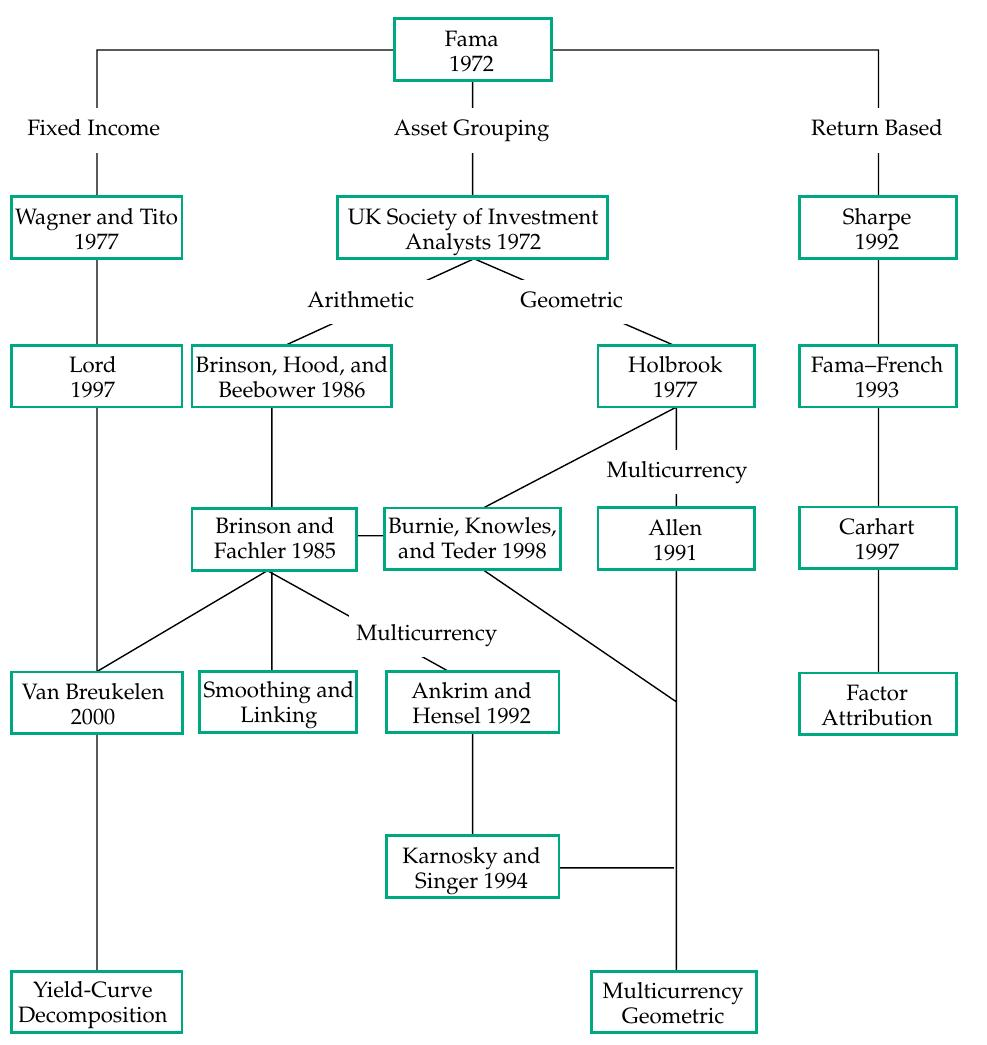

In [27]:
# Relevant images
plt_img_base64(docs[1])

In [ ]:
# Show the image
plt_img_base64(img_base64_list[8])

In [ ]:
# Show the summary of the image
image_summaries[8]

- Run RAG and test the ability to generate an answer to our question.

In [28]:
chain_multimodal_rag.invoke(query)

"Fama Decomposition, introduced by Eugene Fama in 1972, is a method for analyzing the sources of return in an investment portfolio. It breaks down the portfolio's performance into different components to understand the contribution of various factors. The key components include:\n\n1. **Systematic Risk (Beta)**: The return from the portfolio's exposure to market risk, measured by beta, plus the risk-free rate.\n\n2. **Selectivity**: The return from the manager's ability to select securities that outperform the market.\n\n3. **Diversification**: The impact of not being fully diversified, which is the difference between the Fama beta and the portfolio beta.\n\n4. **Net Selectivity**: The remaining return from selectivity after accounting for the cost of not being fully diversified.\n\n5. **Timing**: The return from the manager's ability to vary systematic risk (beta) around a target or policy amount.\n\nFama's decomposition is foundational in performance attribution, helping to identify 

Retrieve the vector store

In [ ]:
# Create retriever
new_retriever = create_multi_vector_retriever(
    vectorstore,
    text_summaries,
    texts,
    table_summaries,
    tables,
    image_summaries,
    img_base64_list,
)

In [34]:
new_chain = multi_modal_rag_chain(new_retriever)

In [ ]:
# Check retrieval
query = "What is Fama Decomposition"
docs = retriever_multi_vector_img.invoke(query)

# Count relevant docs returned
len(docs)

In [ ]:
docs[0]

In [ ]:
new_chain.invoke(query)

In [ ]:
def img_prompt_func(data_dict):
    """
    Join the context into a single string and create a report-style prompt
    """
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # Adding image(s) to the messages if present
    if data_dict["context"]["images"]:
        for image in data_dict["context"]["images"]:
            image_message = {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{image}"},
            }
            messages.append(image_message)

    # Adding the text for report generation
    text_message = {
        "type": "text",
        "text": (
            "You are a professional report writer and analyst. "
            "Generate a detailed report based on the provided information and images. "
            "Your report should:\n"
            "1. Have a clear title related to the query\n"
            "2. Include multiple sections with appropriate headings\n"
            "3. Reference and analyze any charts or graphs provided\n"
            "4. Provide insights and conclusions\n\n"
            f"Topic for the report: {data_dict['question']}\n\n"
            "Available information:\n"
            f"{formatted_texts}\n\n"
            "Please structure your response in a report format with clear sections and analysis of any visualizations provided."
        ),
    }
    messages.append(text_message)
    return [HumanMessage(content=messages)]

def multi_modal_rag_chain(retriever):
    """
    Multi-modal RAG chain with report generation capability
    """
    # Multi-modal LLM with increased token limit for longer reports
    model = ChatOpenAI(
        temperature = 0, 
        model       = "gpt-4o", 
        max_tokens  = 2048,  # Increased token limit for longer reports
        api_key     = ""
    )

    # RAG pipeline
    chain = (
        {
            "context"   : retriever | RunnableLambda(split_image_text_types),
            "question"  : RunnablePassthrough(),
        }
        | RunnableLambda(img_prompt_func)
        | model
        | StrOutputParser()
    )

    return chain

In [29]:
# Check retrieval
query = "Provide a comprehensive analysis of the Fama Decomposition and its implications"
docs = retriever_multi_vector_img.invoke(query)

# Count relevant docs returned
len(docs)

3

In [35]:
for i in range(len(docs)):
    print(f"Document: {i}")
    print(docs[i])

Document: 0
where:  6 = portfolio risk  portfolio risk  6, = benchmark risk  benchmark risk  Therefore, the return required to justify not being fully diversified is cal- culated by using the difference between the Fama beta and the portfolio beta  as follows:  d=(B, -B)x(b-7).  @)  (3)  Note that the “Fama beta will always be greater than or equal to the port- folio beta since total risk is greater than or equal to the systematic risk of the  portfolio” (Bacon 2013, p. 89).  The net return from selectivity (“net selectivity,” for short) is the remain- ing return from selectivity after deducting the amount of return required to  justify not being fully diversified:  Net selectivity = Selectivity — Diversification.  Net selectivity = Selectivity – Diversification.  Net selectivity = Sy,, =a—d.  Net selectivity =  If net selectivity is negative, the portfolio manager has failed to justify the  loss of diversification.  Timing is the return from the manager’s variations in systematic risk

In [33]:
# Redefine the RAG chain to produce reports
chain_multimodal_rag = multi_modal_rag_chain(retriever_multi_vector_img)

# Ask to generate a report
report = chain_multimodal_rag.invoke(query)
print(report)

### Comprehensive Analysis of the Fama Decomposition and Its Implications

#### Overview of Fama Decomposition

Fama's 1972 paper, "Components of Investment Performance," introduced a framework for analyzing the sources of return in an investment portfolio, marking the beginning of performance attribution analysis. The decomposition aims to break down portfolio returns into various components to understand the contribution of different investment decisions.

#### Key Components of Fama Decomposition

1. **Systematic Risk (Beta):**
   - Represents the return from the portfolio's exposure to market risk.
   - Calculated using the portfolio's beta, which measures sensitivity to market movements.

2. **Selectivity:**
   - Measures the ability of the portfolio manager to select securities that outperform the market.
   - Calculated as the difference between the actual portfolio return and the return expected from systematic risk.

3. **Diversification:**
   - Assesses the impact of not bein


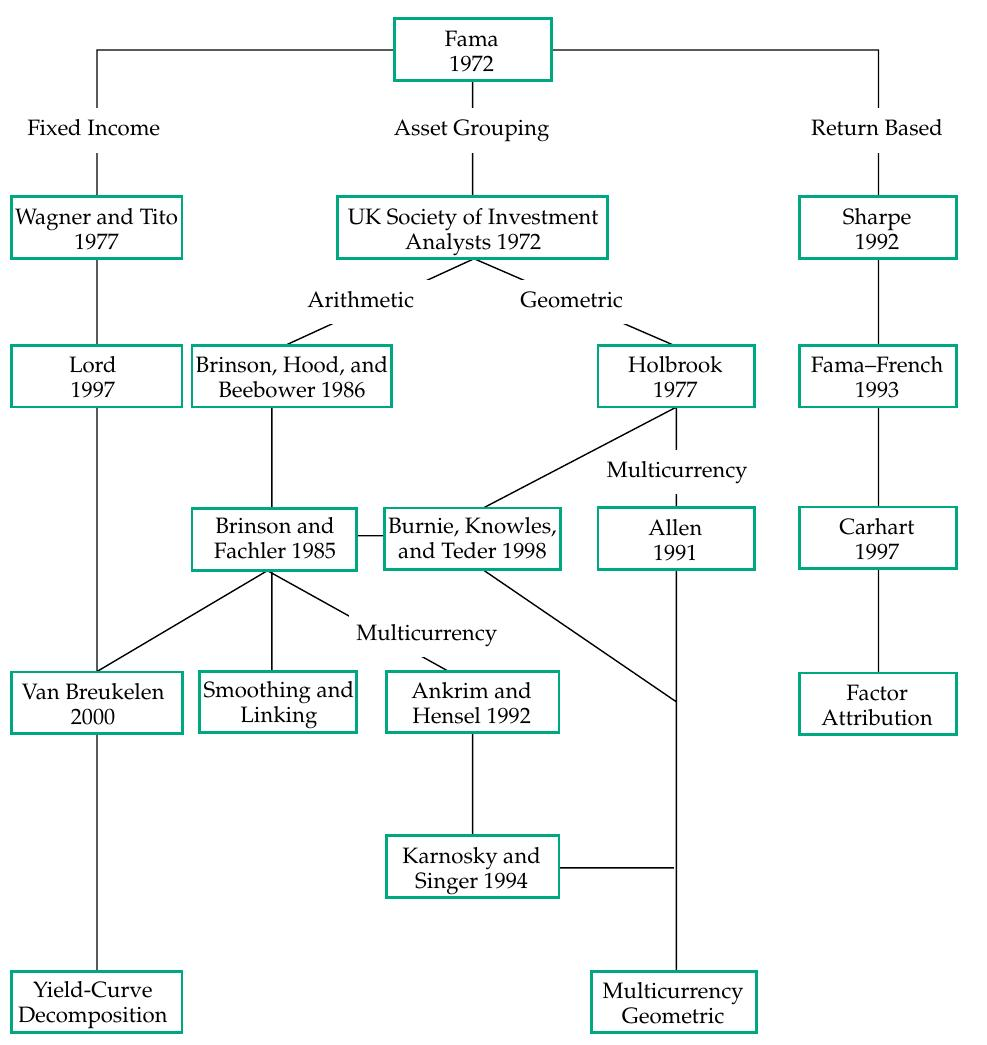

In [34]:
plt_img_base64(docs[1])